# Plotting the graph

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import sys,shutil
from pathlib import Path

import scipy.optimize as syopt
import scipy.special as sysp



import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc
from time import time

# These imports needed for MCMC using Cobaya
from cobaya.yaml import yaml_load_file
from cobaya.run import run

from getdist.mcsamples import MCSamplesFromCobaya,MCSamples
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt

from scipy.optimize import curve_fit

# from polynomials import Polynomials  # imports from ./polynomials.py
# from paths import ML_Path

sys.path.append('../../code/')  # now okay
# sys.path.append(ML_Path)



# import utilities



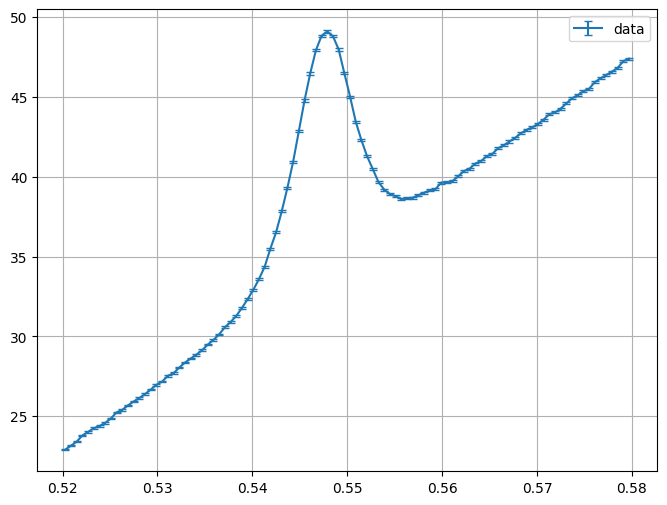

100

In [15]:
df = pd.read_csv("TotalStackedNote.csv")

x = df['bin_center']
y = df['content']
err = df['error']
y = y / 1e4
err = err / 1e4
plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr = err, capsize=3, label = "data")

plt.grid()
plt.legend()
plt.show()
len(x)

# Analytical Solution

[ 4.72631805e+00  5.47194515e-01  5.03924494e-03  1.01220330e+01
  5.47667469e-01  2.53761525e-03 -1.90634798e+02  4.10553062e+02]
paramcov daigonal [4.94729052e-02 1.61437192e-09 6.95287127e-09 4.70526631e-02
 1.62027046e-10 7.53701420e-10 3.65845285e-02 1.22107152e-01]


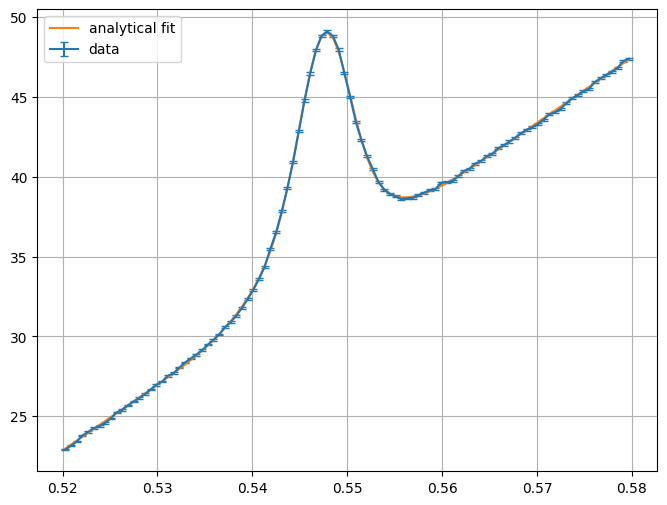

analytical chi  148.61037575650715


In [4]:
def model(x, *gaussCheby):
    A1, mu1, sig1, A2, mu2, sig2,a0, a1 = gaussCheby  
    gauss1 = A1 * np.exp(-((x - mu1)**2) / (2 * sig1**2))
    gauss2 = A2 * np.exp(-((x - mu2)**2) / (2 * sig2**2))  # Fixed: Added "-" before exponent

    cheby = a0 + a1 * x
    
    return gauss1+ gauss2 + cheby





params, param_cov = curve_fit(model, x, y, sigma=err, absolute_sigma=True, p0 = [12, .547, 0.01, 10, .548, .005, 12.5, 500])
print(params)
# print("paramcov",param_cov)
print("paramcov daigonal",param_cov.diagonal())


plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr = err, capsize=3, label = "data")
plt.plot(x, model(x,*params), label = "analytical fit")

plt.grid()
plt.legend()
plt.show()

def chi2(y, data, sigma,x):
    chi = np.sum(((data-y)/sigma)**2)
    dof = len(x) - 8
    return chi

print("analytical chi ",chi2(y, model(x,  *params), err, x))

In [5]:
variances = err**2
cov = np.diag(variances)
cov 

array([[0.00229126, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00231572, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.0023411 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00468209, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00472483,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00474039]], shape=(100, 100))

In [6]:
# import utilities
# utilities.svd_inv(cov)

# MCMC

In [7]:

import likelihood

dim = 8

Run_Cobaya = True
Show_Cobaya = True
Resume = False

Max_Samples = 100000
Rminus1_Stop = 0.01 
Rminus1_CL_Stop = 0.05
Rminus1_CL_Level = 0.99
Burn_In = 0

Latex_List = []
Params_List = []
for m in range(dim):
    Latex_List.append('a_{'+str(m)+'}') 
    Params_List.append('a'+str(m))

print(Latex_List)
info = {}
info['likelihood'] = {'likelihood.Chi2Like':
                      {'python_path':'./',
                       'data':y,
                       'cov_mat':cov}}

info['theory'] = {'likelihood.GaussChebyTheory':
                  {'python_path':'./',
                   'xvals':x}}

info['params'] = {}


info['params']['a0'] = {
    'ref': 12,                                # Inside [-2, 2]
    'prior': {'min': 0, 'max': 20},
    'proposal': .1,
    'latex': 'a_{0}'
}

info['params']['a1'] = {
    'ref': .547,                                # Inside [-2, 2]
    'prior': {'min': .52, 'max': .56},
    'proposal': .001,
    'latex': 'a_{1}'
}
info['params']['a2'] = {
    'ref': .01,                                # Inside [-2, 2]
    'prior': {'min':.0001, 'max': .1},
    'proposal': .001,
    'latex': 'a_{2}'
}
info['params']['a3'] = {
    'ref': 10,                                # Inside [-2, 2]
    'prior': {'min': 0, 'max': 20},
    'proposal': .1,
    'latex': 'a_{3}'
}
info['params']['a4'] = {
    'ref': .548,                                # Inside [-2, 2]
    'prior': {'min':.52, 'max': .56},
    'proposal': .001,
    'latex': 'a_{4}'
}
info['params']['a5'] = {
    'ref': .005,                                # Inside [-2, 2]
    'prior': {'min':.0001, 'max': .1},
    'proposal': .001,
    'latex': 'a_{5}'
}
info['params']['a6'] = {
    'ref': 12.5,                                # Inside [-2, 2]
    'prior': {'min':-200, 'max': 100},
    'proposal': .5,
    'latex': 'a_{6}'
}
info['params']['a7'] = {
    'ref': 500,                                # Inside [-2, 2]
    'prior': {'min':100, 'max': 600},
    'proposal': .5,
    'latex': 'a_{7}'
}






info['sampler'] = {'mcmc':
                   {'learn_proposal': True,
                    'Rminus1_single_split': 4,
                    'measure_speeds': True,
                    'max_samples': Max_Samples,
                    'max_tries': 10000,
                    'Rminus1_stop': Rminus1_Stop,
                    'Rminus1_cl_stop': Rminus1_CL_Stop,
                    'Rminus1_cl_level': Rminus1_CL_Level,
                    'burn_in': Burn_In}}

info['output'] = 'stats/chains/eta/poly_deg{0:d}'.format(dim-1)
if Resume:
    info["resume"] = True
else:
    info["force"] = True
print('... done with setup')


['a_{0}', 'a_{1}', 'a_{2}', 'a_{3}', 'a_{4}', 'a_{5}', 'a_{6}', 'a_{7}']
... done with setup


In [8]:
Run_Cobaya = True  # or False

if Run_Cobaya:
    start_time = time()
    
    updated_info, sampler = run(info)
    

[output] Output to be read-from/written-into folder 'stats/chains/eta', with prefix 'poly_deg7'
[output] Found existing info files with the requested output prefix: 'stats/chains/eta/poly_deg7'
[output] Will delete previous products ('force' was requested).
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: a0:12, a1:0.547, a2:0.01, a3:10, a4:0.548, a5:0.005, a6:12.5, a7:500
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {likelihood.Chi2Like: 6200.0, likelihood.GaussChebyTheory: 2070.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2025-07-10 07:57:12 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 320 samples accepted.
[mcmc]  - Acceptance rate: 0.251
[mcmc]  - Convergence of means: R-1 = 22.369409 after 256 accepted steps
[mcmc]  - Updated covarian

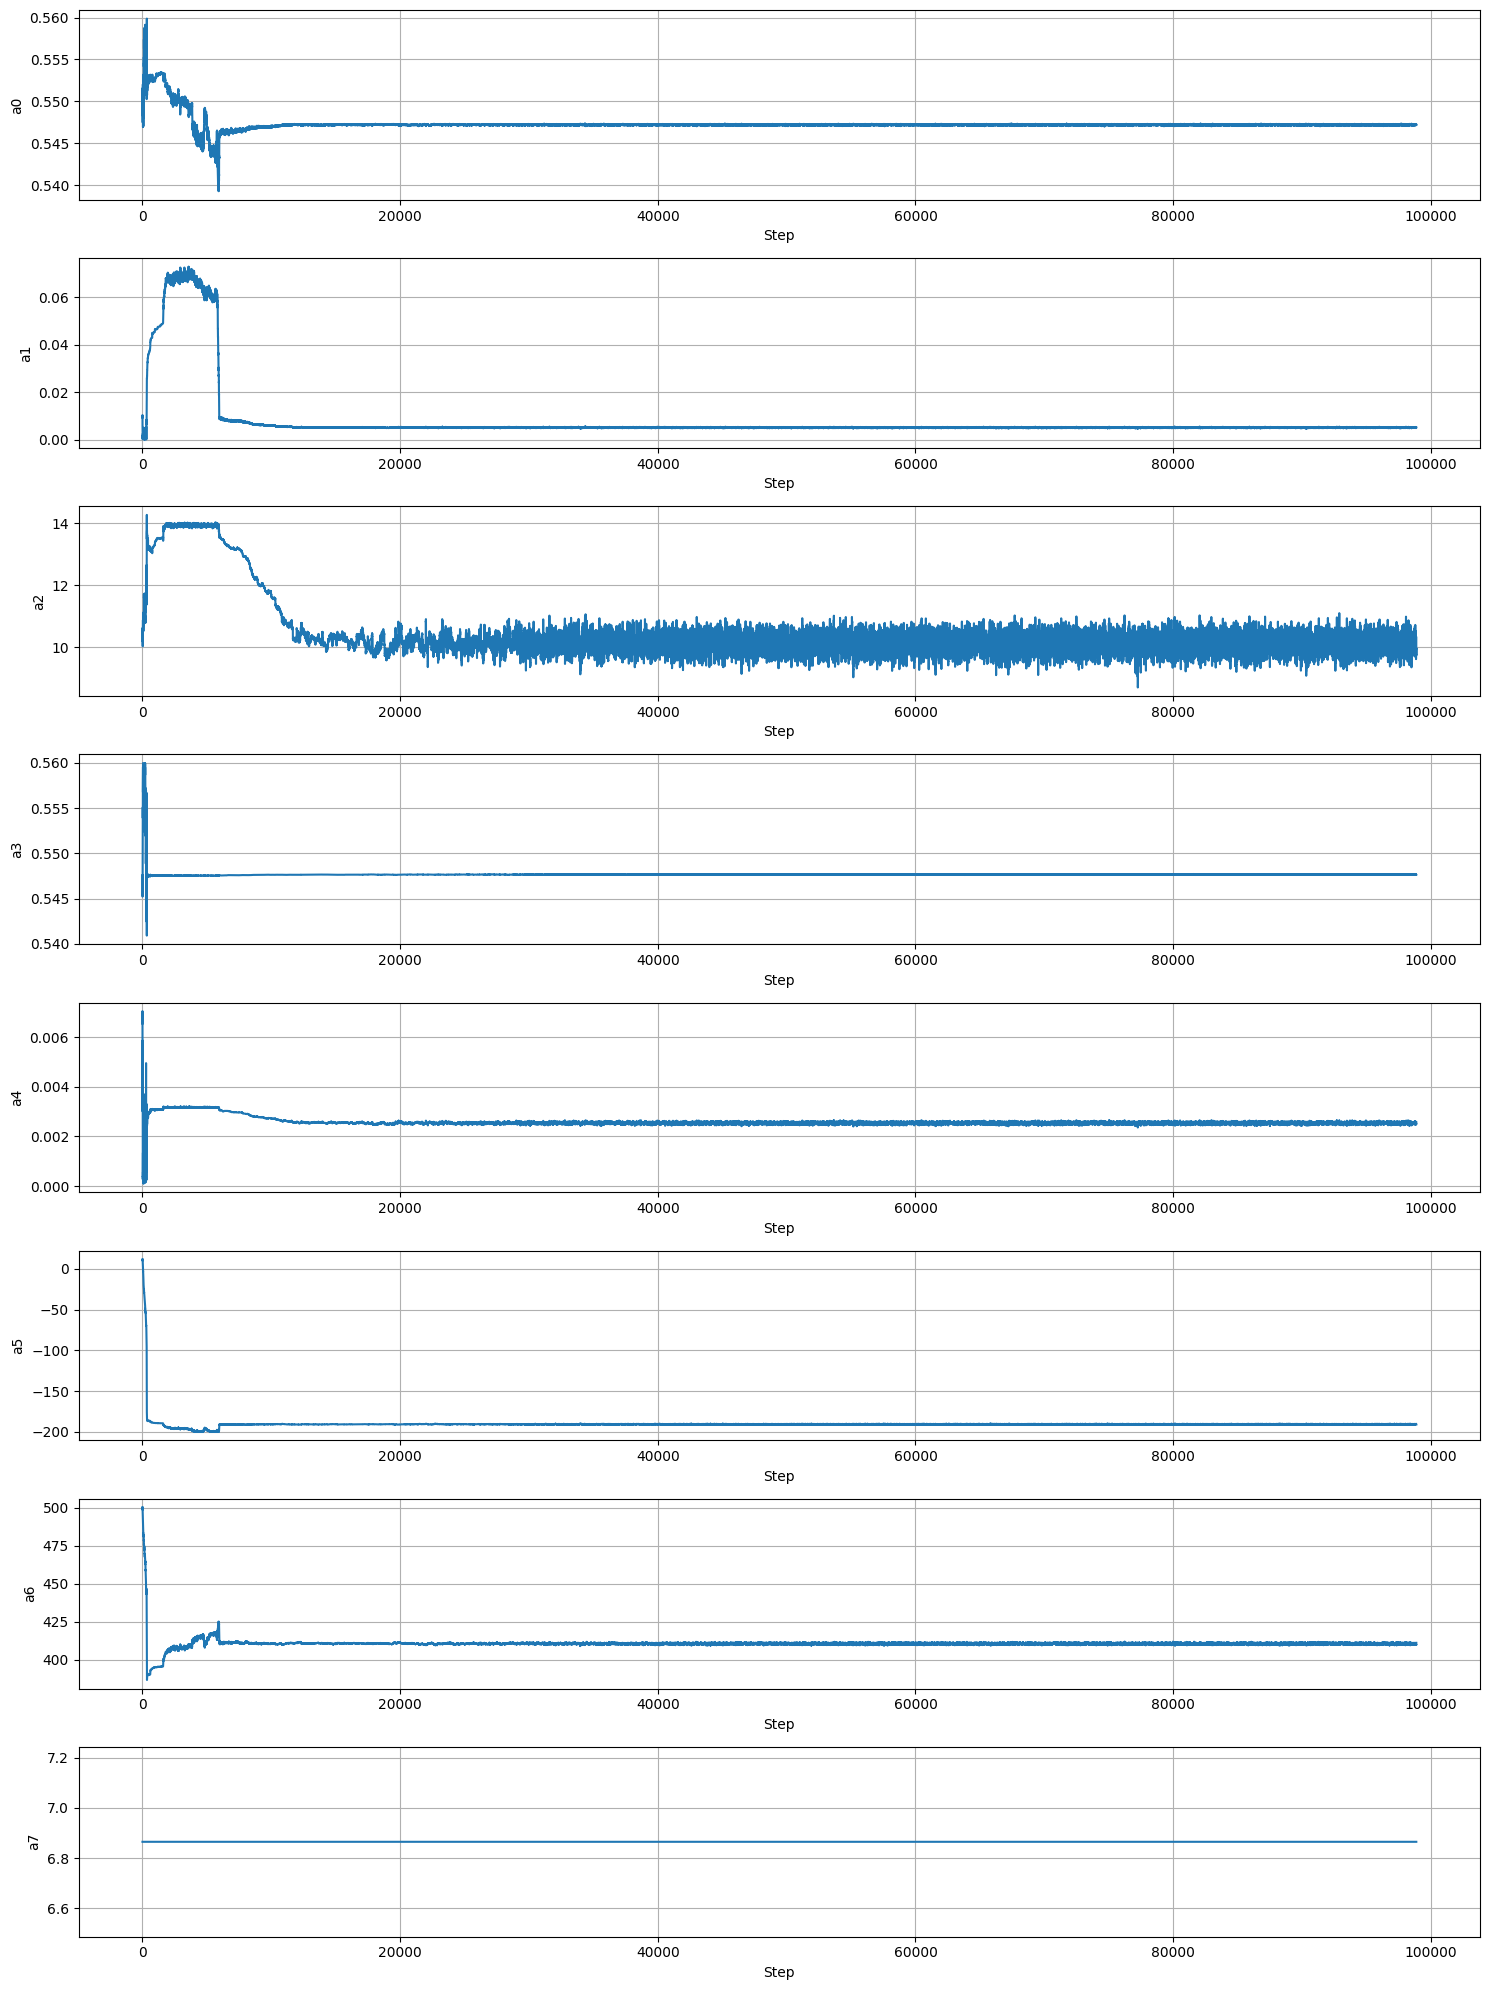

Last accepted parameter values:
a0 = 0.54718398
a1 = 0.0050946127
a2 = 10.319995
a3 = 0.54767048
a4 = 0.0025690807
a5 = -190.94396
a6 = 411.1035
a7 = 6.8649323


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Load the chain, skipping the header
filename = "stats/chains/eta/poly_deg7.1.txt"

# Find how many header lines start with "#"
with open(filename, 'r') as f:
    header_lines = 0
    for line in f:
        if line.startswith('#'):
            header_lines += 1
        else:
            break

# Load the data
data = np.loadtxt(filename, skiprows=header_lines)

# Column index map (based on your screenshot)
columns = {
    "weight": 1,
    "minuslogpost": 2,
    "a0": 3,
    "a1": 4,
    "a2": 5,
    "a3": 6,
    "a4": 7,
    "a5":8,
    "a6":9,
    "a7":10,
    "minuslogprior": 8
}

# List of parameters you want to plot
params_text = ["a0", "a1", "a2", "a3", "a4","a5","a6", "a7"]

# Plot each parameter vs steps
plt.figure(figsize=(15, 2.5 * len(params_text)))
for i, p in enumerate(params_text):
    plt.subplot(len(params_text), 1, i + 1)
    plt.plot(data[:, columns[p]])
    # plt.xlim((150000,175000))
    plt.ylabel(p)
    plt.xlabel("Step")
    plt.grid(True)

plt.tight_layout()
plt.show()

# Print last accepted value of each parameter
print("Last accepted parameter values:")
for p in params_text:
    print(f"{p} = {data[-1, columns[p]]}")


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import getdist.plots as gdplt
from getdist.mcsamples import loadMCSamples
import gc
from time import time


ncomp = dim // 2        # number of (a, b) pairs




# MCMC plotting and analysis
Show_Cobaya = True
Burn_In = 0.2  # or 0.3, depending on your setup

# Replace this with your actual Cobaya output info
info = {
    "output": 'stats/chains/eta/poly_deg{0:d}'.format(dim-1) # assumes files like mysim.1.txt, mysim.info exist
}

FS1, FS2, FS3 = 16, 14, 12  # Font sizes

if Show_Cobaya:
    start_time = time()
    
    # Load GetDist MCMC samples
    gd_sample = loadMCSamples(info["output"], settings={'ignore_rows': Burn_In})
    mcmc_covmat = gd_sample.getCovMat().matrix[:dim, :dim]
    
    # Load raw MCMC samples
    sample = np.loadtxt(info["output"] + '.1.txt')
    sample = sample[int(Burn_In * sample.shape[0]):]  # remove burn-in
    sample = sample.T
    
    ibest = sample[1].argmin()  # best-fit index (lowest -lnlike)
    mcmc_best = sample[2:2+dim, ibest]
    mcmc_chi2 = sample[dim+4, ibest]
    mcmc_sig = np.sqrt(np.diag(mcmc_covmat))
    
    print('MCMC results:')
    print(f"... best fit (a,b pairs): " + ", ".join(f"{v:.4f}" for v in mcmc_best))
    print(f"... std dev           : " + ", ".join(f"{v:.4f}" for v in mcmc_sig))
    print(f"... best chi2: {mcmc_chi2:.3f}")



    # Bootstrap confidence bands
    Nsample = gd_sample.samples.shape[0]
    N_boot = min(1000, int(0.2 * sample[0].size))
    poly_boot = np.zeros((N_boot, x.size))
    
    rng = np.random.default_rng(seed=42)
    indices = rng.choice(Nsample, size=N_boot, replace=False)
    
    for i, idx in enumerate(indices):
        params_i = sample[2:2+dim, idx]
        poly_boot[i] = model(x, *params_i)
    
    poly_16pc = np.percentile(poly_boot, 16, axis=0)
    poly_84pc = np.percentile(poly_boot, 84, axis=0)
    
    del poly_boot
    gc.collect()


    # plt.errorbar(x, y, yerr=err, fmt='o', ms=5, lw=1, capsize=4, label='Data', color='black')
    # plt.plot(x, y, ls=':', color='gray', lw=2, label='True model')
    # plt.plot(x, model(x, *mcmc_best), ls='-', color='indigo', lw=2, alpha=0.8, label='MCMC best fit')
  
    
    # plt.xlabel('$x$', fontsize=FS1)
    # plt.ylabel('$y(x)$', fontsize=FS1)
    # plt.title(f'eta fit ', fontsize=FS1)
    # plt.legend(fontsize=FS2)
    # # plt.ylim((4,5))
    # plt.grid(True, alpha=0.3)
    # plt.tight_layout()
    # plt.show()
print("curvefit chi2")
def model(x, *gaussCheby):
    A1, mu1, sig1, A2, mu2, sig2,a0, a1 = gaussCheby  
    gauss1 = A1 * np.exp(-((x - mu1)**2) / (2 * sig1**2))
    gauss2 = A2 * np.exp(-((x - mu2)**2) / (2 * sig2**2))  # Fixed: Added "-" before exponent

    cheby = a0 + a1 * x
    
    return gauss1+ gauss2 + cheby

params = [4.72631805e+00,5.47194515e-01,5.03924494e-03,1.01220330e+01,5.47667469e-01,2.53761525e-03,-1.90634798e+02,4.10553062e+02]
y_curve_fit = model(x, *params)

def chi2(data,y,sig):
    dof = len(x)- 8
    chi = np.sum(((data-y)/err)**2)
    return chi

residuals = y - model(x, *params)
noise_sigma = np.std(residuals, ddof=1)

print(chi2(y, y_curve_fit, noise_sigma))

MCMC results:
... best fit (a,b pairs): 4.7293, 0.5472, 0.0050, 10.1159, 0.5477, 0.0025, -190.5685, 410.4314
... std dev           : 0.2628, 0.0000, 0.0001, 0.2512, 0.0000, 0.0000, 0.1938, 0.3532
... best chi2: 148.873
curvefit chi2
148.61037576249606


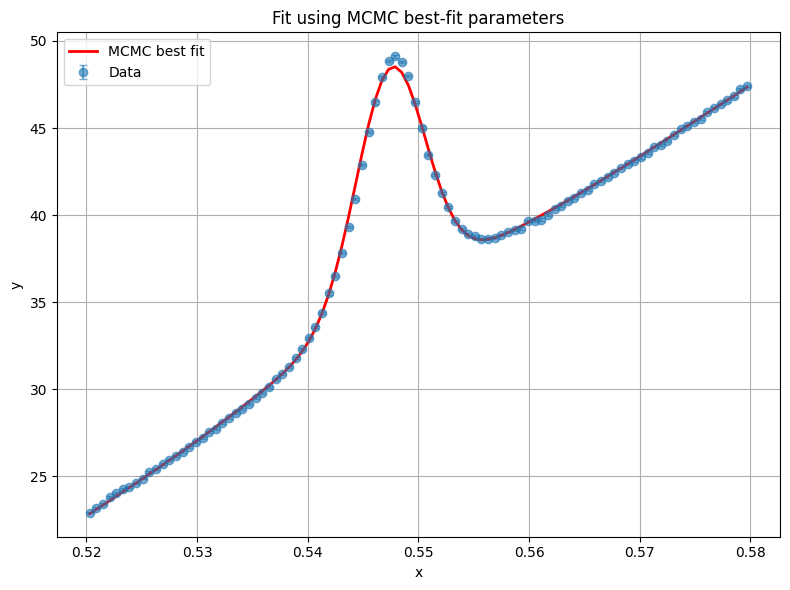

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Original data (replace with your real arrays)
# x = np.array([...])
# y = np.array([...])
# err = np.array([...])

# MCMC best fit values from the image
params_mcmc = [13.1097, 0.5475, 0.0031, 1.3179, 0.5465, 0.0086, -191.9483, 412.7886]
# MCMC standard deviations (1σ uncertainties)
errors_mcmc = [0.4540, 0.0001, 0.0001, 4.3729, 0.0095, 0.0239, 4.3226, 9.6283]

def model(x, A1, mu1, sig1, A2, mu2, sig2, a0, a1):
    gauss1 = A1 * np.exp(-((x - mu1)**2) / (2 * sig1**2))
    gauss2 = A2 * np.exp(-((x - mu2)**2) / (2 * sig2**2))
    cheby = a0 + a1 * x
    return gauss1 + gauss2 + cheby

# Generate best-fit model
y_fit = model(x, *params_mcmc)

# Plotting
plt.figure(figsize=(8,6))
plt.errorbar(x, y, yerr=err, fmt='o', capsize=3, label='Data', alpha=0.6)
plt.plot(x, y_fit, label='MCMC best fit', color='red', lw=2)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Fit using MCMC best-fit parameters")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


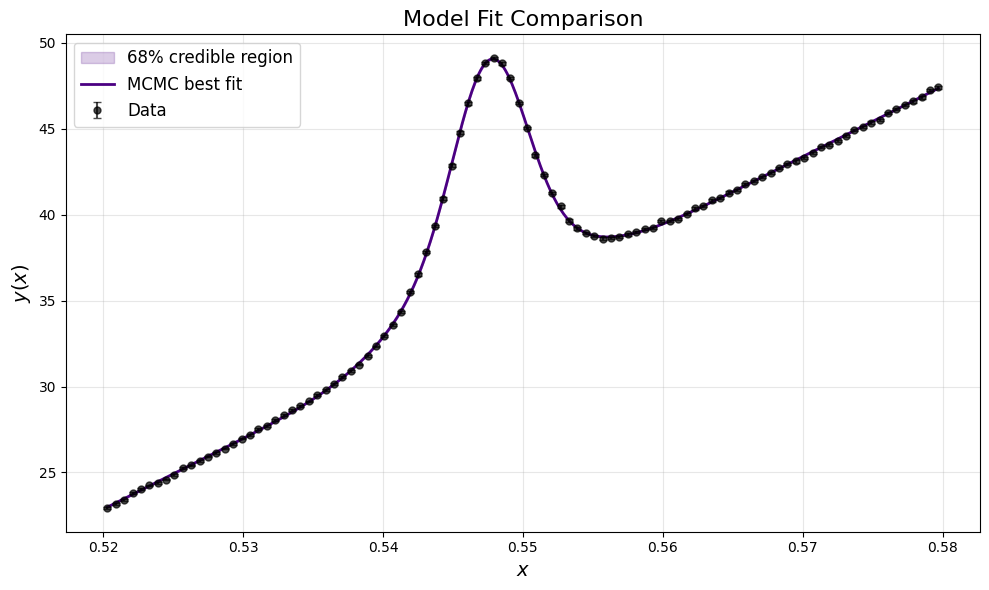

In [12]:

mcmc_best_original = mcmc_best

# Rescale all samples for posterior prediction
samples_original = gd_sample.samples[:, :dim] 
# Generate predictions (using original-scale model)
x_plot = np.linspace(x.min(), x.max(), 500)
best_fit = model(x_plot, *mcmc_best_original)

# Posterior predictive (using a subset of samples)
predicted = np.array([model(x_plot, *params) for params in samples_original[:1000]])

# Calculate confidence bands
lower = np.percentile(predicted, 16, axis=0)
upper = np.percentile(predicted, 84, axis=0)

# Plotting
plt.figure(figsize=(10,6))
plt.fill_between(x_plot, lower, upper, color='indigo', alpha=0.2, 
                 label='68% credible region')
plt.plot(x_plot, best_fit, '-', color='indigo', lw=2, 
         label='MCMC best fit')
plt.errorbar(x, y, yerr=err, fmt='o', ms=5, capsize=3, 
             label='Data', color='black', alpha=0.7)




plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y(x)$', fontsize=14)
plt.title('Model Fit Comparison', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a1. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a2. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a5. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a2. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a3. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a5. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a7. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a2, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a2, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a2, a7. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a3, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a3, a5. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a3, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a4, a5. Using fallback width: f(a) and f(b) must have different signs


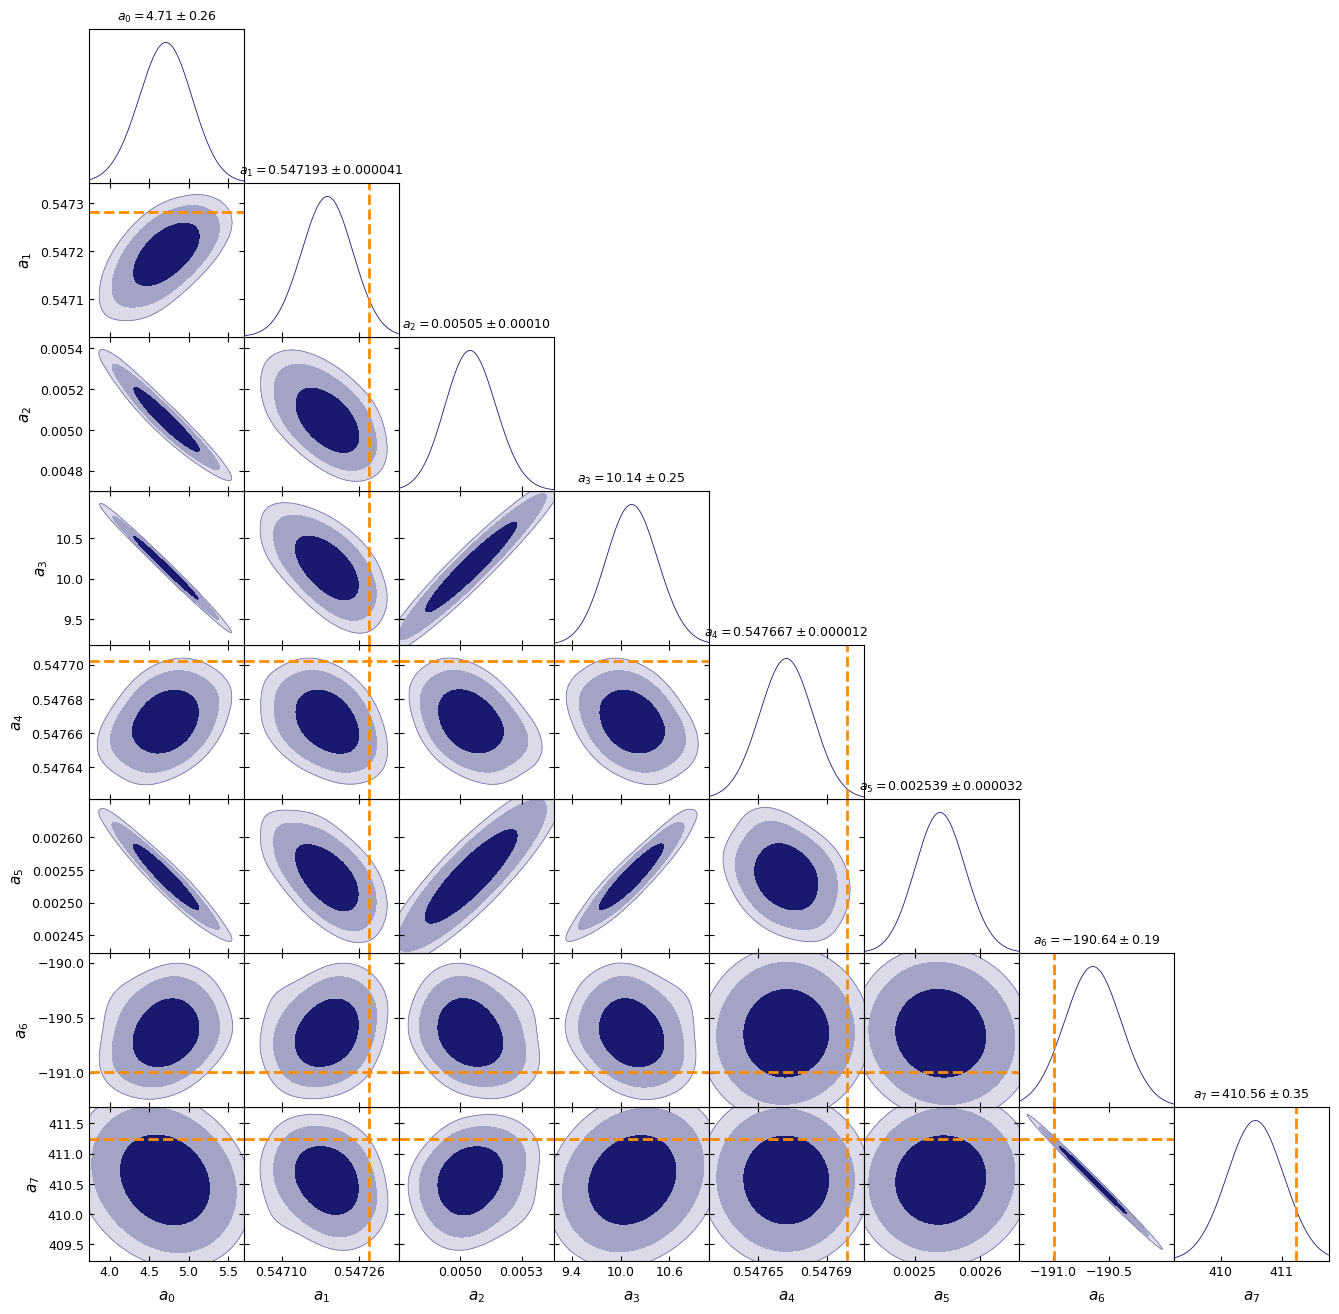

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import getdist.plots as gdplt
from getdist.mcsamples import loadMCSamples

# === Configuration ===
burn_in_fraction = 0.2  # discard initial 10% of samples
# params_list = ["a1", "mu1", "sig1", "a2", "mu2", "sig2", "a0", "a1"]
dim = len(Params_List)

# Update with your actual Cobaya output prefix (without `.txt` or `.yaml`)
output_prefix = "stats/chains/eta/poly_deg7"  # Change this if your chain is stored elsewhere

# Load the MCMC samples
samples = loadMCSamples(output_prefix, settings={'ignore_rows': burn_in_fraction})

# Optional: extract best-fit for marker placement
raw_chain = np.loadtxt(output_prefix + ".1.txt")
raw_chain = raw_chain[int(burn_in_fraction * raw_chain.shape[0]):]  # Apply burn-in
logpost = raw_chain[:, 1]  # log-posterior values
params = raw_chain[:, 2:2+dim]  # skip weight and logpost columns
best_index = np.argmax(logpost)
best_fit_params = params[best_index]

# Create triangle plot
plotter = gdplt.get_subplot_plotter()
plotter.settings.num_plot_contours = 3
plotter.settings.axes_fontsize = 12
plotter.settings.axes_labelsize = 14

fig = plotter.triangle_plot([samples], Params_List,
                            filled=True,
                            contour_colors=['midnightblue'],
                            markers=best_fit_params,
                            marker_args={'c': 'darkorange', 'ls': '--', 'lw': 2},
                            title_limit=1)

plt.show()


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a1. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a2. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a5. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a0, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a2. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a3. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a5. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a1, a7. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a2, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a2, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a2, a7. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a3, a4. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a3, a5. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a3, a6. Using fallback width: f(a) and f(b) must have different signs


[root] *WARNING* 2D kernel density bandwidth optimizer failed for a4, a5. Using fallback width: f(a) and f(b) must have different signs


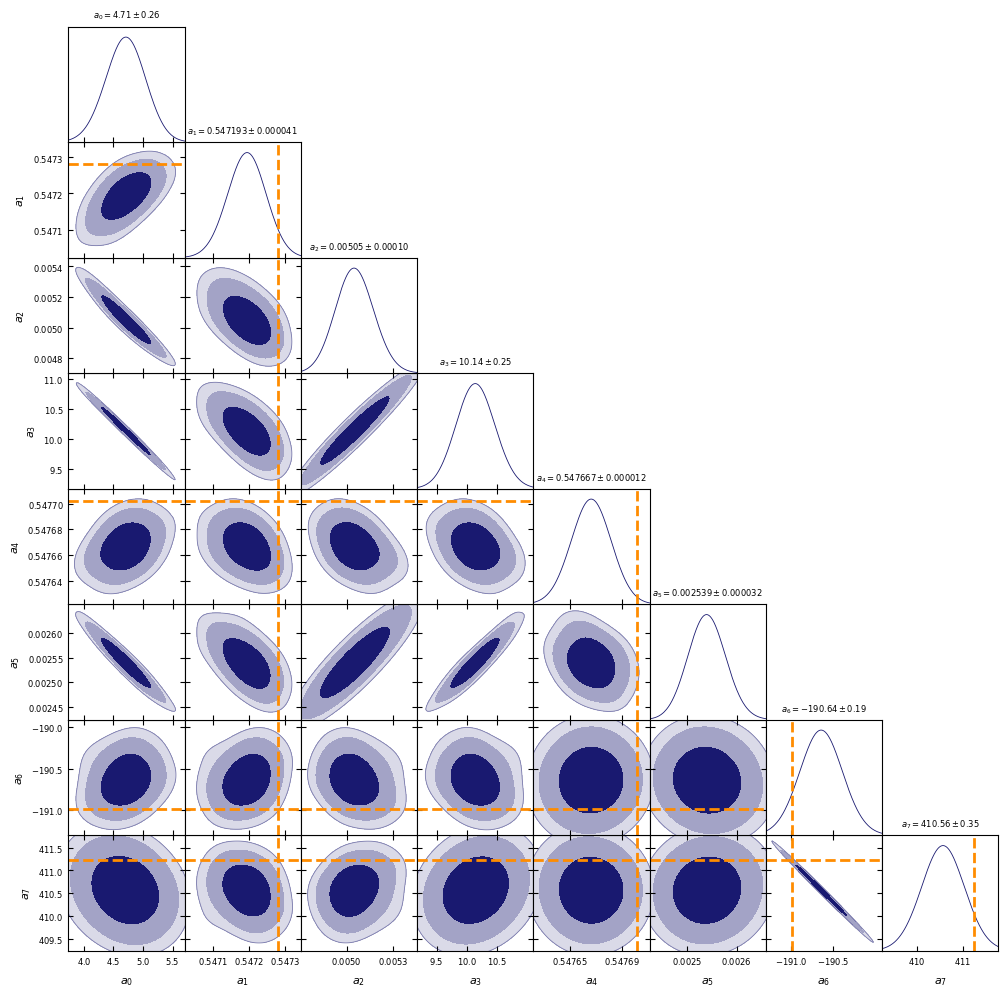

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import getdist.plots as gdplt
from getdist.mcsamples import loadMCSamples

# === Configuration ===
burn_in_fraction = 0.2  # discard initial 10% of samples
# Replace with your actual list of parameter names
Params_List = ["a0", "a1", "a2", "a3", "a4", "a5", "a6", "a7"]
dim = len(Params_List)

# Update with your actual Cobaya output prefix (without `.txt` or `.yaml`)
output_prefix = "stats/chains/eta/poly_deg7"  # Adjust if needed

# Load the MCMC samples
samples = loadMCSamples(output_prefix, settings={'ignore_rows': burn_in_fraction})

# Extract best-fit for marker placement
raw_chain = np.loadtxt(output_prefix + ".1.txt")
raw_chain = raw_chain[int(burn_in_fraction * raw_chain.shape[0]):]  # Apply burn-in
logpost = raw_chain[:, 1]  # log-posterior values
params = raw_chain[:, 2:2+dim]  # skip weight and logpost
best_index = np.argmax(logpost)
best_fit_params = params[best_index]

# Create triangle plot
plotter = gdplt.get_subplot_plotter()
plotter.settings.figure_legend_frame = False
plotter.settings.num_plot_contours = 3
plotter.settings.axes_fontsize = 10
plotter.settings.axes_labelsize = 12

# Adjust figure size for full box visibility
# plotter.settings.figure_width_inch = 12
plotter.settings.fig_width_inch = 12
plotter.settings.tight_layout = True
plotter.settings.tight_layout = [0.02, 0.02, 0.98, 0.98]  # [left, bottom, right, top]
# plotter.settings.tight_layout

# Generate triangle plot
plotter.triangle_plot([samples], Params_List,
                      filled=True,
                      contour_colors=['midnightblue'],
                      markers=best_fit_params,
                      marker_args={'c': 'darkorange', 'ls': '--', 'lw': 2},
                      title_limit=1)

plt.show()
